# Run R faster than light (well, faster than R's own C-level functions) using rpy2 and Numba

**Abstract:** Using rpy2 together with the python-to-LLVM compiler `numba` we are able to create very time-efficient R functions, and achieve faster run times than R's own C-level optimized functions. This notebook is taking the reader through the simple steps required to produce such functions and measure their performances, first by implementing a computation of the mean that goes faster than R's own C-implemented function, and second by implementing a sliding window (something frequently used in finance or when looking at genomic sequences).

## Introduction

We believe that the ability to create easily software prototypes is extremely beneficial for exploratory and creative work by providing a support for concepts and ideas. This includes technical and scientific efforts.

The ideal prototype will scale a little, so it can be tried in more situation or on larger data sets, and this will often require optimizing for speed.

With Python there exists several ways to speed up Python code. The most notable are:
- Pypy: a alternative implementation of Python using a JIT compiler
- Cython: an hybrid language between Python and C compiling to C
- C-API: write C extension, or write a C library and use `ctypes` or `cffi`
- Numba: a relatively new alternative using JIT compilation for LLVM

Pypy and Cython are exciting projects, but we are not looking at them in this notebook: `rpy2` is not yet working with Pypy, and Cython uses an hybrid language between C and Python. We will not consider the use of the C-API either because we would like to see here if we could provide an acceleration of R code through the use of rpy2 and without writing anything else than regular Python.

We use the R package importer in `rpy2`:

In [1]:
from rpy2.robjects.packages import importr

## First example: computing the average

For our first example, we will compute the average of a vector. We create an R vector of random values from a normal distribution.

In [2]:
stats = importr('stats')
vector = stats.rnorm(5000)

The average is simply the sum of all values divided by the number of values: 

\begin{equation*} \mu = \frac{1}{n} \left( \sum_{k=i}^n e_i \right) \end{equation*}


In [3]:
sum(vector)/len(vector)

0.005933412360394009

Python has also a function to compute this directly.

In [4]:
import statistics
statistics.mean(vector)

0.005933412360393977

If we consider the two examples above we had a Python function operate on an R vector (exposed through `rpy2`). We will focus on this before considering how our functions could be called from R.

For our experiment with accelerating Python code, we will simply consider a straightforward implementation to compute the mean:

- we loop over the elements in the input sequence in order to sum them
- we divide this sum by the number of elements in the input sequence

That function is decorated with the numba JIT builder, and the input and output are specified (vector of floats for the former, float for the latter).

In [5]:
import numba

@numba.jit(numba.float64(numba.float64[:]))
def mean_nb(v):
    #ignore the case where v is of length 0
    res = 0
    for x in v:
        res += x
    return res / len(v)

Trying this function on our R vector is unfortunately not working, presumably 
because numba does not seem to recognize the Python buffer protocol.

In [6]:
try:
    mean_nb(vector)
except TypeError as ex:
    print('%s: %s' % (type(ex).__name__, ex))

TypeError: No matching definition


While a fix might be available by the time one is reading this notebook ( https://github.com/numba/numba/issues/989 )
in the meantime we can use the feature in `rpy2` that allows one to build
numpy arrays from rpy2 vectors without making a copy of the data.

Numba is able to recognize numpy arrays is this sufficient to apply our function
to the data.

In [7]:
import numpy
mean_nb(numpy.asarray(vector))

0.005933412360394009

### Benchmark

#### Initial results

Now how fast is this ?

The answer is **very fast**. Faster than numpy's C implementation for `mean()`.

In [8]:
v = numpy.asarray(vector)

print('Naive Python:')
%timeit sum(v)/len(v)

print('\nPython\'s statistics module:')
%timeit statistics.mean(v)

print('\nNaive Numba:')
%timeit mean_nb(v)

print('\nNumpy:')
%timeit numpy.mean(v)

print('------')

Naive Python:
1000 loops, best of 3: 614 µs per loop

Python's statistics module:
100 loops, best of 3: 11.6 ms per loop

Naive Numba:
100000 loops, best of 3: 6.33 µs per loop

Numpy:
The slowest run took 7.09 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 22.5 µs per loop
------


### Calling Python functions from R

Now can we use the numba JIT-ted function from within R ? The answer is yes.


`rpy2` offers the opportunity to `rternalize` any Python function, that is expose that function to R as if it was an R function. `rternalize` can be used as a decorator, and we rewrite our function by just adding that decorator:

In [9]:
from rpy2.rinterface import rternalize

@rternalize
@numba.jit(numba.float64(numba.float64[:]))
def mean_nb_r(v_r):
    v = numpy.asarray(v_r)
    #ignore the case where v is of length 0
    res = 0
    for x in v:
        res += x
    return res / len(v)

When exposed to Python, that function is indeed an R function.

In [10]:
mean_nb_r

<rpy2.rinterface.SexpClosure - Python:0x7f981d1e8a68 / R:0x3ff2c70>

Our test vector can be used with it.

In [11]:
tuple(mean_nb_r(vector))

(0.005933412360394009,)

After loading the notebook's extension to handle R code

In [12]:
%load_ext rpy2.ipython
%Rdevice svg

In [13]:
%%R
m <- matrix(rnorm(500, 5000), nrow=500, ncol=5000)
system.time(apply(m, 1, mean))

   user  system elapsed 
  0.342   0.004   0.346 


In [14]:
%%R -i mean_nb_r
system.time(apply(m, 1, mean_nb_r))

   user  system elapsed 
  0.316   0.016   0.330 


### Performance and vector size

Under certain conditions, faster-than-C results can be achieved whenever R vectors of larger size are used. Gimmick aside, the performances are very good.

Whenever testing for NAs with the numba function the performances appear to collapse but this is presumably either because I am missing something with numba or there is a problem with the version I am using.

In [15]:
from rpy2.rinterface import NA_Real
nareal = NA_Real.real
@rternalize
@numba.jit(numba.float64(numba.float64[:], numba.boolean))
def mean_nb_na_r(v_r, na_rm):
    v = numpy.asarray(v_r)
    #ignore the case where v is of length 0
    res = 0
    for x in v:
        if x == nareal:
            if na_rm:
               continue
            else:
               return nareal
        res += x
    return res / len(v)

In [16]:
%%R -i mean_nb_r -i mean_nb_na_r

suppressMessages(require("dplyr"))

r_mean <- function(x){
    s <- 0
    for (elt in x) {
        s <- s + elt
    }
    s / length(x)
}
rcomp_mean <- compiler::cmpfun(r_mean)
null <- function(vector) { return(NULL) }
l <- list()
list_nx <- list(list(100, rnorm(100)),
            list(100, rnorm(1000)),
            list(50, rnorm(10000)),
            list(20, rnorm(100000)),
            list(10, rnorm(500000)),
            list(10, rnorm(1000000)),
            list(5, rnorm(1500000)))
for (nx in list_nx) {
  n <- nx[[1]]
  x <- nx[[2]]
  l <- c(l, list(
              list(f=null, label="None (cost of call)", n=n, x=x),
              list(f=mean_nb_r, label="numba", n=n, x=x),
              #list(f=mean_nb_na_r, label="numba (handle NA)", n=n, x=x),
              list(f=mean, label="R (C)", n=n, x=x),
              list(f=r_mean, label="R", n=n, x=x),
              list(f=rcomp_mean, label="R (byte-compiled)", n=n, x=x)))
}
func_benchmark <- function (l) {
    data.frame(user.self = system.time(replicate(l$n,
                                                 l$f(l$x)))["user.self"],
               n = l$n,
               size = length(l$x),
               label = l$label)
}

res <- bind_rows(lapply(l,
                        func_benchmark))

In [17]:
%%R

# add numba with handling of NAs
l <- list()
for (nx in list_nx) {
  n <- nx[[1]]
  x <- nx[[2]]
  l <- c(l, list(
              list(f=mean_nb_na_r, label="numba (handle NA)", n=n, x=x)))
}
func_benchmark <- function (l) {
    data.frame(user.self = system.time(replicate(l$n,
                                                 l$f(l$x, TRUE)))["user.self"],
               n = l$n,
               size = length(l$x),
               label = l$label)
}

res <- bind_rows(res,
                 bind_rows(lapply(l, func_benchmark)))

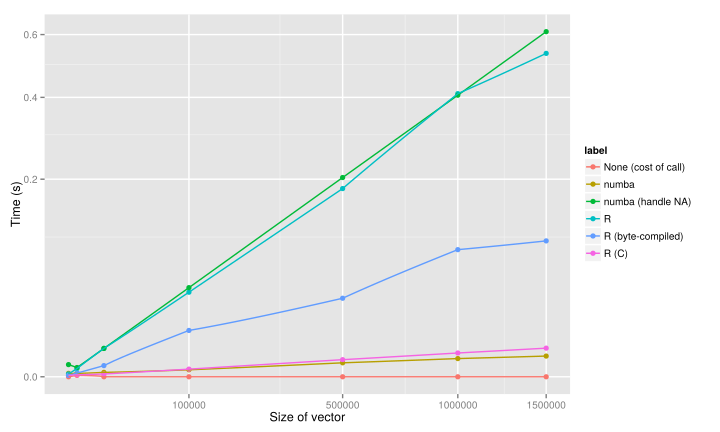

In [18]:
%%R -w 10
library(ggplot2)
p <- ggplot(res) + 
  geom_point(aes(y=user.self/n, x=size, color=label)) +
  geom_line(aes(y=user.self/n, x=size, color=label)) +
  scale_x_continuous('Size of vector', breaks=c(100000, seq(500000, 2000000, by=500000))) +
  scale_y_continuous('Time (s)') +
  coord_trans(x = "sqrt", y = "sqrt")
print(p)

## Second example: sliding window

For this second example, we consider the running mean or mean over a sliding window.

The R implementation is simple and uses subsetting and C-level code rather than R-level loops.

In [19]:
%%R
slide_mean <- function(vector, width, step){
  n <- length(vector)
  indices <- seq(1, n-width, by=step)
  result <- numeric(length = length(indices))
  for(i in 1:length(indices)){
    result[i] <- mean(vector[indices[i]:(indices[i]+width)])
  }
  return(result)
}

The Python implementation is also straightforward.

As seen earlier, we can nest the `rternalization` and the JIT compiling of the Python function:

In [20]:
import numba
from rpy2.rinterface import rternalize

@rternalize
@numba.jit(numba.float64(numba.float64[:], numba.int64, numba.int64))
def slide_r(vec_r, w, s):
    vec = numpy.asarray(vec_r)
    w = w[0]
    s = s[0]
    #ignore the case where v is of length 0
    res = numpy.ndarray((len(vec)//s, ), dtype=numpy.float64)
    for res_i, i in enumerate(range(0, len(vec)-w, s)):
        m = 0
        for j in range(0, w):
            m += vec[i+j]
        m = m / w
        res[res_i] = m
    return res

In [21]:
%%R
suppressMessages(require("inline"))
suppressMessages(require("Rcpp"))
src <- "
Rcpp::NumericVector xvector(vector);
Rcpp::IntegerVector xwidth(width);
Rcpp::IntegerVector xstep(step);

int n_vec = xvector.size();
int w = xwidth[0];
int s = xstep[0];
double m;
Rcpp::NumericVector res((int)n_vec / s);
int res_i = 0;
for (int i = 0; i < n_vec; i += s) {
  m = 0;
  for (int j = 0; j < w; j++) {
    m += xvector[i+j];
  }
  m = m / w;
  res[res_i] = m;
  res_i += 1;
}
return res;
"
slide_rcpp <- cxxfunction(signature(vector = "numeric", width = "integer", step = "integer"),
                          src, plugin = "Rcpp")


In [22]:
%%R -i slide_r
suppressMessages(require("dplyr"))

rcomp_slide_mean <- compiler::cmpfun(slide_mean)

l <- list()
for (fl in list(list(slide_mean, "R"),
                list(rcomp_slide_mean, "R (byte-compiled)"),
                list(slide_rcpp, "R (Rcpp-compiled)"),
                list(slide_r, "numba"))) {
    f <- fl[[1]]
    label <- fl[[2]]
    for (nx in list(list(100, 1:100),
                    list(100, 1:500),
                    list(10, 1:1000),
                    list(5, 1:5000),
                    list(1,  1:10000))) {
          n <- nx[[1]]
          x <- nx[[2]]
          l <- c(l, list(list(f=f, n=n, x=x, w=10, s=1, label=label)))
    }
}

func_benchmark <- function (l) {
    data.frame(user.self = system.time(replicate(l$n,
                                                 l$f(l$x, l$w, l$s)))["user.self"],
               n = l$n,
               size = length(l$x),
               label = l$label)
}

res <- bind_rows(lapply(l,
                        func_benchmark))

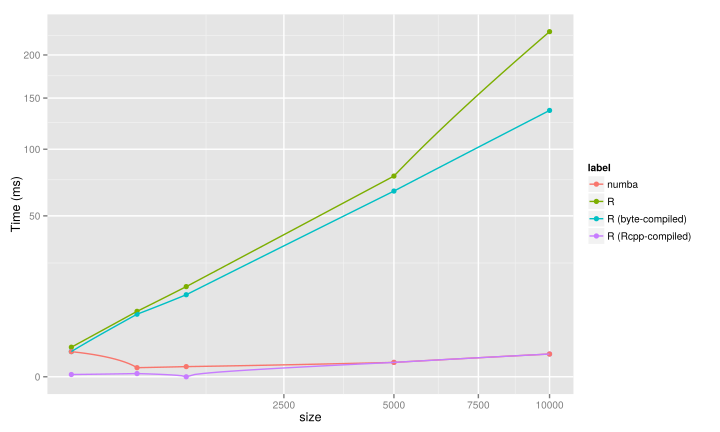

In [23]:
%%R -i slide_r -w 10
require("ggplot2")
p <- ggplot(res) + 
  geom_point(aes(y=user.self*1000/n, x=size, color=label)) +
  geom_line(aes(y=user.self*1000/n, x=size, color=label)) +
  coord_trans(x = "sqrt", y= "sqrt") +
  #scale_x_continuous('Size of vector', breaks=c(100000, seq(500000, 2000000, by=500000))) +
  scale_y_continuous('Time (ms)')
print(p)

This time the speed gain is extremely large, and byte-compiling R is no match. If extrapolating, a sequence of size 4E6 (the number of DNA bases in some bacterial genomes for example) would be rather long with R and rather quick with the numba function. 

## Conclusion

We have shown that Python, `rpy2`, and `numba` can be used to create very efficient functions that be used directly by an embedded R process.